# Pointcloud Segmentation Based on Geometry

In this notebook we will use planes and volumes to segment the pointcloud

In [1]:
import open3d as o3d
import numpy as np
from pcd_utils import read_intrinsics, load_rgbd_image, load_pcd, draw_3d, get_3d_box
import os

obj = 'brownie'
view = 'mid'
idx = 162

intrinsics_path = os.path.join('img', obj, f'calib_data_{view}.json')
color_path = os.path.join('img', obj, f'{view}_color_{idx}.jpg')
depth_path = os.path.join('img', obj, f'{view}_depth_{idx}.png')

print(intrinsics_path, color_path, depth_path, sep='\n')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
img/aromaticas/calib_data_mid.json
img/aromaticas/mid_color_70.jpg
img/aromaticas/mid_depth_70.png


## Utility functions for Loading Objects

In [2]:
cam_params, intrinsics = read_intrinsics(intrinsics_path)
#cam_params
intrinsics.intrinsic_matrix

array([[600.86297607,   0.        , 319.60574341],
       [  0.        , 600.86297607, 244.78125   ],
       [  0.        ,   0.        ,   1.        ]])

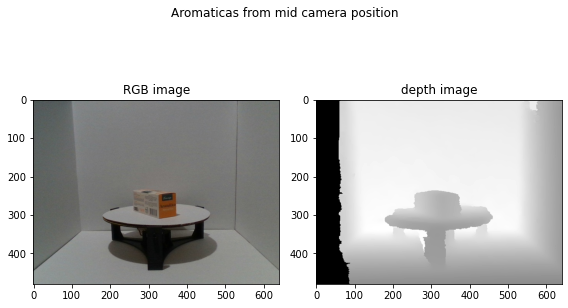

In [3]:
import matplotlib.pyplot as plt

rgbd = load_rgbd_image(color_path, depth_path)

plt.figure(figsize=(8,5))
plt.suptitle(f"{obj.title()} from {view} camera position")
plt.subplot(1, 2, 1)
plt.title('RGB image')
plt.imshow(rgbd.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd.depth, cmap='gray')
plt.tight_layout()
plt.show()

In [4]:
_, pcd = load_pcd(color_path, depth_path, intrinsics_path, d_scale=1, color_pcd=True)

print(pcd)

PointCloud with 307200 points.


In [5]:
origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

draw_3d([origin_frame, pcd])

## Segmentation By Cropping a Given Volume

### Volume Definition

In [16]:
obj_cylinder = o3d.geometry.TriangleMesh.create_cylinder(
    radius=0.14, height=0.2
)
obj_cylinder.compute_vertex_normals()
obj_cylinder.paint_uniform_color([0.1, 0.9, 0.1])
# rotations matrix, x axis rotation
ang = 97
ang *= np.pi / 180
c0 = np.cos(ang)
s0 = np.sin(ang)
rot_x = np.array([
    [1, 0,  0],
    [0,c0,-s0],
    [0,s0, c0]
])
# rotation matrix, z axis rotation
ang = -1.3
ang *= np.pi / 180
c0 = np.cos(ang)
s0 = np.sin(ang)
rot_z = np.array([
    [c0, -s0, 0],
    [s0,  c0, 0],
    [0,    0, 1]
])
rotation = np.dot(rot_z, rot_x)
trans = [0.0, -0.0485, 0.58]
obj_cylinder.rotate(rotation)
obj_cylinder.translate(trans)
#obj_cylinder.transform([
#   [1,  0,  0, -0.01],
#    [0,  0, -1, -0.075],
#    [0,  1,  0, 0.58],
#    [0,  0,  0, 1]
#])

draw_3d([pcd, obj_cylinder, origin_frame])
#o3d.visualization.draw_geometries([pcd, obj_cylinder, origin_frame])
bbox = obj_cylinder.get_oriented_bounding_box()
print(bbox)
bbox.color = [0, 1, 0]

obj_pcd = pcd.crop(bbox)
print(obj_pcd)
obj_pcd.paint_uniform_color([1,0,0])

o3d.visualization.draw_geometries([obj_pcd, pcd, origin_frame, bbox])

OrientedBoundingBox: center: (-6.97278e-18, -0.0485, 0.58), extent: 0.2, 0.27699, 0.27699)
PointCloud with 7141 points.


### Loading a Predefined Volume

In [6]:
print(obj, view)
bbox = get_3d_box(obj, view)
print(bbox)
bbox.color = [0, 1, 0]
o3d.visualization.draw_geometries([pcd, origin_frame, bbox])

aromaticas mid
OrientedBoundingBox: center: (9.77164e-18, -0.0485, 0.58), extent: 0.2, 0.279899, 0.279899)


### Point Cloud Cropping

In [13]:
obj_pcd = pcd.crop(bbox)
print(obj_pcd)
obj_pcd.paint_uniform_color([1,0,0])

#draw_3d([obj_pcd, pcd, origin_frame])
#o3d.visualization.draw_geometries([obj_pcd, pcd, origin_frame, bbox])
o3d.visualization.draw_geometries([obj_pcd, pcd, origin_frame])

PointCloud with 7141 points.


### DBSCAN Refinement

In [14]:
# finding clusters with dbscan
cluster_labels = np.array(
    obj_pcd.cluster_dbscan(eps=0.01, min_points=70)
)
n_clusters = cluster_labels.max() + 1
print(f"Point clod has {n_clusters} cluster(s)")

# coloring clusters
colors = plt.get_cmap("tab10")(cluster_labels / n_clusters if n_clusters > 0 else 1)
colors[cluster_labels < 0] = 0
obj_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

# cluster sizes
cluster_sizes = [len(np.where(cluster_labels==j)[0]) for j in np.unique(cluster_labels)]
# print cluster size and its corresponding label sorted in descending order
print(sorted(zip(cluster_sizes, np.unique(cluster_labels)), reverse=True, key=lambda x: x[0]))
# discard noise
obj_pcd_cluster = obj_pcd.select_by_index(np.where(cluster_labels>=0)[0])

# find largest cluster
# obj_cluster=int(np.unique(cluster_labels)[np.where(cluster_sizes==np.max(cluster_sizes))[0]])
# extracting largest cluster
#obj_pcd_cluster = obj_pcd.select_by_index(np.where(cluster_labels==obj_cluster)[0])

# visualization
obj_pcd_cluster.paint_uniform_color([1,0,0])
draw_3d([obj_pcd_cluster, pcd, origin_frame])

#draw_3d([obj_pcd_cluster, pcd, origin_frame])


Point clod has 1 cluster(s)
[(7093, 0), (48, -1)]


### Segmenting Object

In [18]:
dists = pcd.compute_point_cloud_distance(obj_pcd_cluster)
dists = np.asarray(dists)
inliers = np.where(dists == 0)[0]
draw_3d([pcd.select_by_index(inliers)])

### Obtaining Binary Image Mask

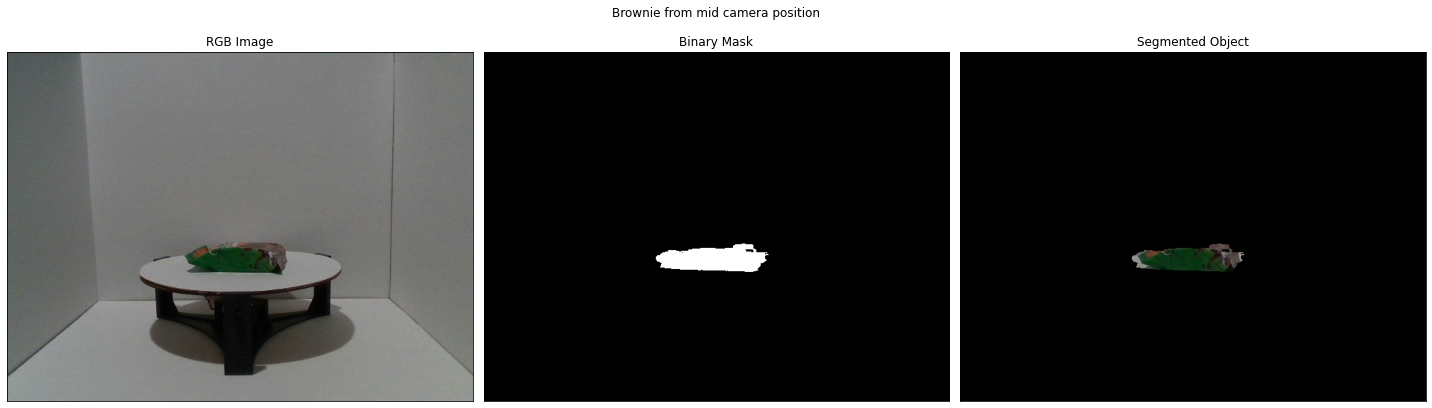

In [19]:
import cv2
import imageio

# create mask
h, w = 480, 640
mask = np.zeros((h*w,1), dtype=np.uint8)
mask[inliers] = 255
mask = mask.reshape((h,w))

rgb_img = imageio.imread(color_path)

masked = cv2.bitwise_and(rgb_img, rgb_img, mask=mask)

imgs = [rgbd.color, mask, masked]
titles = ["RGB Image", "Binary Mask", "Segmented Object"]

plt.figure(figsize=(20,6))
plt.suptitle(f"{obj.title()} from {view} camera position")
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 3, i+1)
    plt.title(title)
    if np.asarray(img).ndim == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap="gray")
    plt.tick_params(
        bottom = False,
        labelbottom = False,
        left = False,
        labelleft= False
    )
plt.tight_layout()
plt.show()

# Testing Processing utility function

In [12]:
from pcd_utils import segment_object

#obj = 'brownie'
#view = 'front'
#idx = 0

intrinsics_path = os.path.join('img', obj, f'calib_data_{view}.json')
color_path = os.path.join('img', obj, f'{view}_color_{idx}.jpg')
depth_path = os.path.join('img', obj, f'{view}_depth_{idx}.png')
mask_path = os.path.join('img', obj, f'{view}_mask_{idx}.png')

_, pcd = load_pcd(color_path, depth_path, intrinsics_path)
print(pcd)

bbox = get_3d_box(obj, view)
print(bbox)

cropped = pcd.crop(bbox)
print(cropped)

#o3d.visualization.draw_geometries([pcd, bbox])


PointCloud with 307200 points.
OrientedBoundingBox: center: (1.00085e-17, -0.048, 0.58), extent: 0.2, 0.27999, 0.27999)
PointCloud with 9709 points.
